# Calculate projection effects in redmapper

Authors Matt Kwiecien, Matteo Costanzi

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Note - we're using relative imports because this code is not technically a module (anymore).  
# It was a module in the original repo, but copied here. Correct imports/module in other repo.
from sigma_z import DC2SigmaZ, CosmoDC2SigmaZ, LambdaModel
from plot_helper import PlotHelper
from data_loader import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The PlotHelper has a lot of boilerplate code to build plots with the correct font size and colors.

In [16]:
PlotHelper.set_defaults(matplotlib)

# Choose between DC2 and CosmoDC2 here.  This will determine which config we use
catalog_to_use = "cosmoDC2"
catalog_compare = "DC2"


Here we specify the following: 
* The z-range and step size used by redmapper 
* The config file which specifies the column mappings
* The model we want to use to fit the $\lambda(z)$ curves

In [17]:
# z-scan redmapper inputs
zstart = 0.1
zend = 1.15
zstep = 0.005

config = f'config/zscan_config_{catalog_to_use.lower()}.yaml'
if catalog_to_use == "DC2":
    myCat = DC2SigmaZ(config, LambdaModel, zstart, zend, zstep)
else:
    myCat = CosmoDC2SigmaZ(config, LambdaModel, zstart, zend, zstep)
    
data = myCat.get_data()

z_in = data['z_in']
lambda_in = data['lambda_in']
lambda_arrays = data['lambda_arrays']

`delta_z` sets the redshift range around `z_in` used to fit the data. 

From Matteo Costanzi:
>The smaller the value the better the fit to the peak of $\lambda(z)$.  Increase the value to fit also the tail of $\lambda(z)$. `delta_z=0.1` is a good compromise to correctly fit clear l.o.s. systems and moderately disturbed ones

`delta_lambda` sets the lowever values of $\lambda(z)$ (relative to the maximum $\lambda(z)$ values) used in the fit

Matteo:
>A value of 20% is recommended in real data to avoid fitting the often disturbed tails of the $\lambda(z)$ distribution



In [18]:
delta_z = 0.1
delta_lambda = 0.2

Here we fit one $\lambda(z)$ curve, and plot the fitted curve to the actual.  

Use the below to compare model fit vs actual data for an individual case-by-case basis.

0.6296452941128956 0.12333167569540868 9.759625261425022


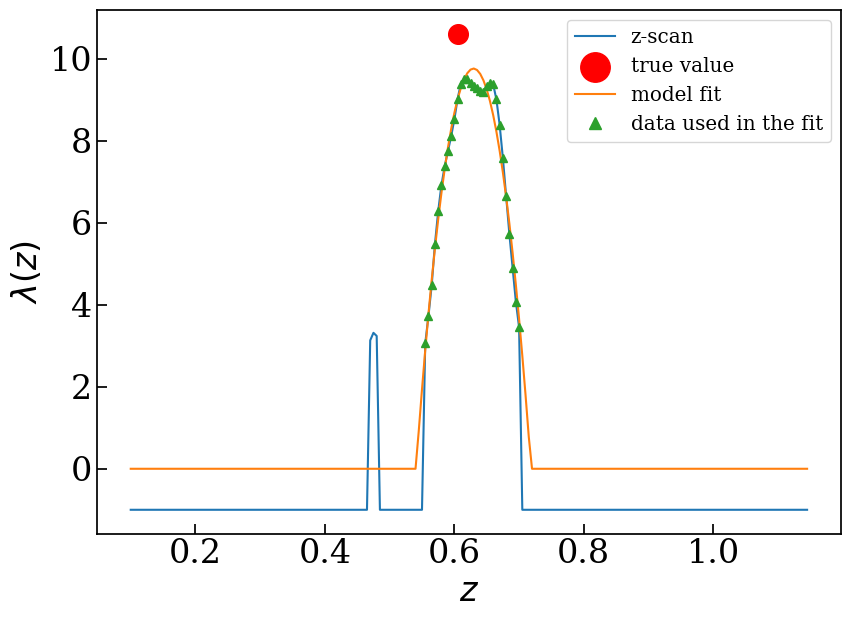

In [19]:
idx=800# Index of the cluster you want to check
fit = myCat.fit_model_by_id(idx, z_in[idx], lambda_in[idx], lambda_arrays[idx], delta_z, delta_lambda)

z_best = fit['z_best']
sigmaz_best = fit['sigmaz_best']
lambda_best = fit['lambda_best']

print(z_best, sigmaz_best, lambda_best)

PlotHelper.plot_model_vs_data(plt, LambdaModel, z_best, sigmaz_best, lambda_best, z_in[idx], lambda_in[idx], myCat.z_domain, lambda_arrays[idx], delta_z, delta_lambda)

Define sig_z_kernel according to Eq. 9 of the Projection effect paper (https://arxiv.org/pdf/1807.07072.pdf)

With this transformation `sig_z_kernel` represents the width of the parabola used to fit $\lambda(z)$

Great. Let's proceed with every other cluster and save the outputs.

In [20]:
# Multiprocessed
model_fits = myCat.fit_model_all(z_in, lambda_in, lambda_arrays, delta_z, delta_lambda)

chis = model_fits['chis_all']
zpeaks = model_fits['zpeak_all']
lambda_peaks = model_fits['lambdapeak_all']
sigmaz_all = model_fits['sigmaz_all']
sig_z_kernel = model_fits['sig_z_kernel']

At cluster 0
At cluster 500
At cluster 1000
At cluster 1500
At cluster 2000
At cluster 2500
At cluster 3000
At cluster 3500
At cluster 4000
At cluster 4500
At cluster 5000
At cluster 5500
At cluster 6000
At cluster 6500
At cluster 7000
At cluster 7500
At cluster 8000
At cluster 8500
At cluster 9000
At cluster 9500
At cluster 10000
At cluster 10500
At cluster 11000
At cluster 11500
At cluster 12000
At cluster 12500
At cluster 13000
At cluster 13500
At cluster 14000
At cluster 14500
At cluster 15000
At cluster 15500
At cluster 16000
At cluster 16500
At cluster 17000
At cluster 17500
At cluster 18000
At cluster 18500
At cluster 19000
At cluster 19500
At cluster 20000
At cluster 20500
At cluster 21000
At cluster 21500
At cluster 22000
At cluster 22500
At cluster 23000
At cluster 23500
At cluster 24000
At cluster 24500
At cluster 25000
At cluster 25500
At cluster 26000
At cluster 26500
At cluster 27000
At cluster 27500
At cluster 28000
At cluster 28500
At cluster 29000
At cluster 29500
At c

Plot the chis distribution (note this is not the $\chi^2$ value). You can use chis to assess the goodness of the fit, e.g. see below

Text(0.5, 1.0, 'Goodness-of-fit (100 bins)')

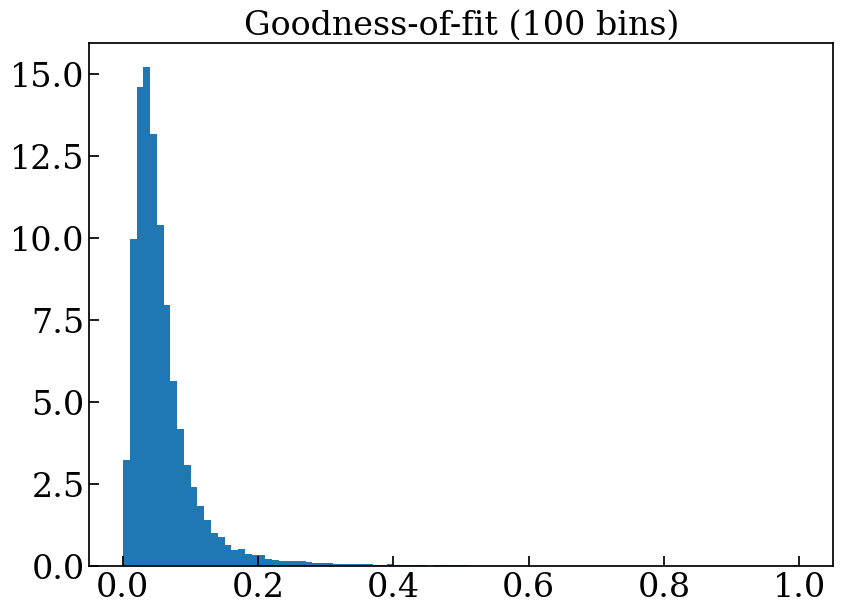

In [21]:
plt.hist(chis,bins=100,density=True)
plt.title("Goodness-of-fit (100 bins)", fontsize=24)

Below is a helper method to help visually inspect poor model fits.  Provide the condition as well as the model and the helper function will return a plot of 10 fits that match your condition.

Here we're looking at plots where our goodness-of-fit is worse than 0.2

1221


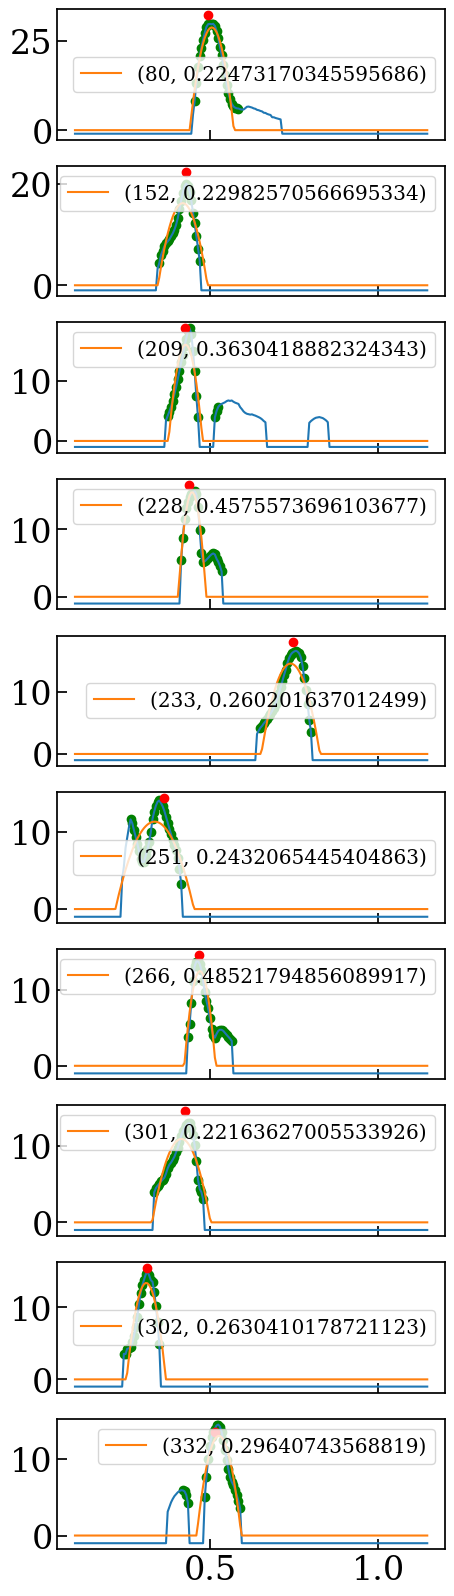

In [22]:
# Example of a systems with bad chis
cond=(chis>0.2)

PlotHelper.plot_sample(
    plt, cond, z_in, myCat.z_domain, 
    lambda_arrays, lambda_in, LambdaModel, sigmaz_all, zpeaks, 
    lambda_peaks, chis
)

Based on the above, we decided outliers lie beyond `chi=0.2` and `sig_z_kernel > 1`.  Here we filter out that data, and plot the scatter plot. 

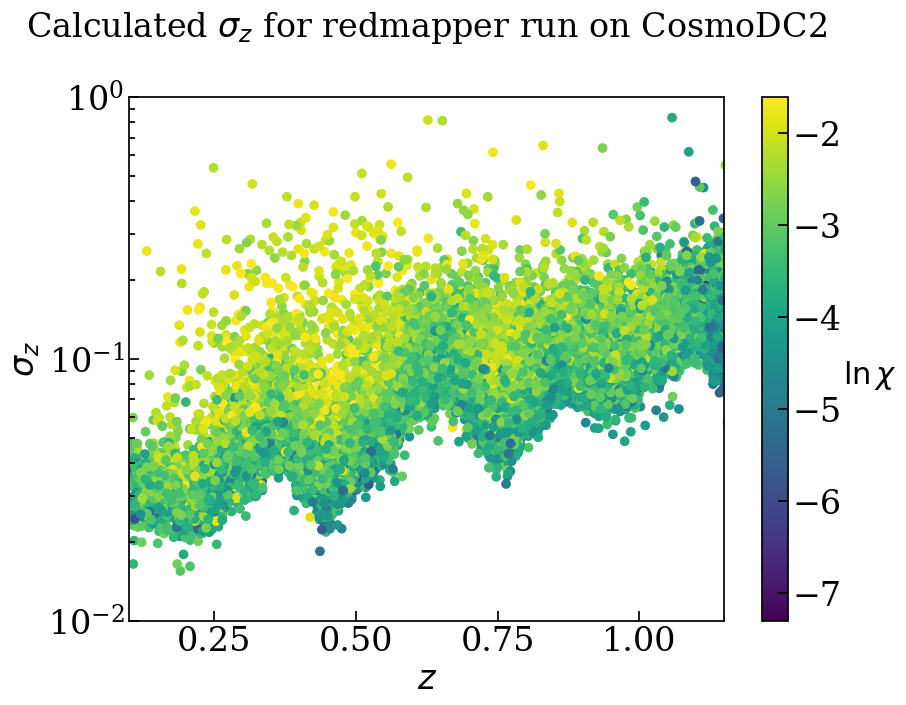

In [23]:
chi_filter = 0.2
sig_z_filter = 1
combined_filter = (chis <= chi_filter) & (sig_z_kernel < 1)

sigma_z_filtered = sig_z_kernel[combined_filter]
z_peaks_filtered = zpeaks[combined_filter]
chis_filtered = chis[combined_filter]

PlotHelper.plot_sigmaz_scatter(plt, z_peaks_filtered, sigma_z_filtered, chis_filtered)

Now, we average the `sig_z_kernel` in each bin, and plot the results vs other known real and simulated catalogs.

Calculating the average, and standard deviation of the mean for each richness bin:

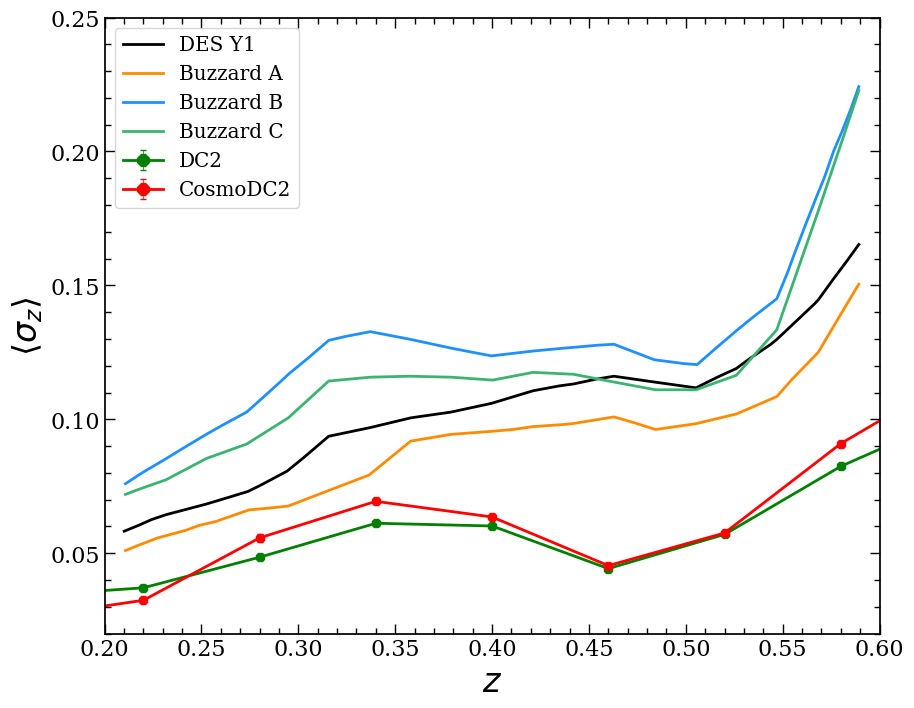

In [24]:
bin_start = 0.1
bin_end = 1.16
step_size = 0.06
(avg, sem, z_bins) = myCat.average_by_bin(z_peaks_filtered, sigma_z_filtered, bin_start, bin_end, step_size)

import math
sem = [0 if math.isnan(x) else x for x in sem]
# Load in comparison data (can re-do this using the above)
comparison_data = pickle.load(open(f"data/{catalog_compare}_values.pkl", "rb"))


fig, ax = plt.subplots(1,1, figsize=(10, 8))
PlotHelper.plot_avg_combined_plot(fig, ax, plt, z_bins, avg, sem, comparison_data)

If you'd like to pickle these results you can do so below, then load them and plot them against other catalogs.

In [12]:
import pickle
saveData = {}
saveData['sz'] = avg
saveData['err'] = sem
saveData['bins'] = z_bins
pickle.dump(saveData, open(f"data/{catalog_to_use}_values.pkl", "wb"))